# **Анализ временных рядов с помощью Python. Метод экспоненциального сглаживания (модель ETS)**

## **Cодержание**


- Теория 
    - Модель ETS
    - Модификации модели ETS
    - Полезные ссылки
- Практика 
    - Установка библиотеки
    - Данные
    - Обучение модели
    - Прогнозирование
    - Автоматический подбор модели
    - Сравнение моделей с помощью скользящего окна







## **Теория**

Наряду с уже известными моделями прогнозирования, такими как ARMA, ARIMA, GARCH, существует еще не такой известный в русской литературе класс моделей ETS, в основе которых лежит экспоненциальное сглаживание. 

Экспоненциальное сглаживание - метод прогнозирования, при котором значения переменной за все предыдущие периоды входят в прогноз, экспоненциально теряя свой вес со временем. Это позволяет модели с достаточной степенью гибко реагировать на новейшие изменения в данных, сохраняя при этом информацию об историческом поведении временного ряда.

В простейшей форме экспоненциальное сглаживание выглядит как

$$Прогноз: \hat y_{t+h|t} = l_t$$

$$Сглаживание: l_t = \alpha y_t + (1-\alpha)l_{t-1},$$

где $y_t$ – значение переменной $y$ в момент времени $t$, $\hat y_{t+h|t}$ – прогноз на период $t + h$ по значениям $y$ до $t$, $\alpha$ – настраиваемый параметр.

Раскрыв скобки в выражении для сглаживания, мы получим следущее:

$$l_t = \alpha y_t + (1-\alpha)l_{t-1} = l_{t-1} + \alpha(y_t - l_{t-1}) = l_{t-1} + \alpha \epsilon_t,$$ где $\epsilon_t = y_t - l_{t-1} = y_t - \hat y_{t+h|t}$ - ошибка прогноза (т.е. разница между истинным и спрогнозированным значением) в момент времени $t$.
 

# Модель ETS


Модель ETS состоит из трех компонентов:
- **e**rror $(\epsilon_t)$ - ошибка
- **t**rend $(b_t)$ - тренд
- **s**easonality $(s_t)$ - сезонность

Каждый компонент может быть аддитивными (A) или мультипликативными (M), а также отсутствовать в модели (N) [кроме ошибки], что обычно отражается в названии модели. Например, ETS(A,N,N) содержит аддитивные ошибки и не содержит ни тренда, ни сезонного фактора.

**Аддитивная модель** является линейной и предполагает, что компоненты складываются

 $y_t = Trend + Seasonality + Error$ , то есть тренд выражен прямой линией, а сезонность имеет одинаковую частоту (ширина циклов) и амплитуду (высота циклов).

**Мультипликативная модель**  является нелинейной и предполагает, что компоненты перемножаются

 $y_t = Trend \cdot Seasonality \cdot Error$, то есть тренд выражен изогнутой линией, а сезонность имеет возрастающую или уменьшающуюся частоту и/или амплитуду во времени.


Перед определением типа каждого компонента обычно смотрят на графическое представление временного ряда, определяя линейность/нелинейность тренда и сезонности.

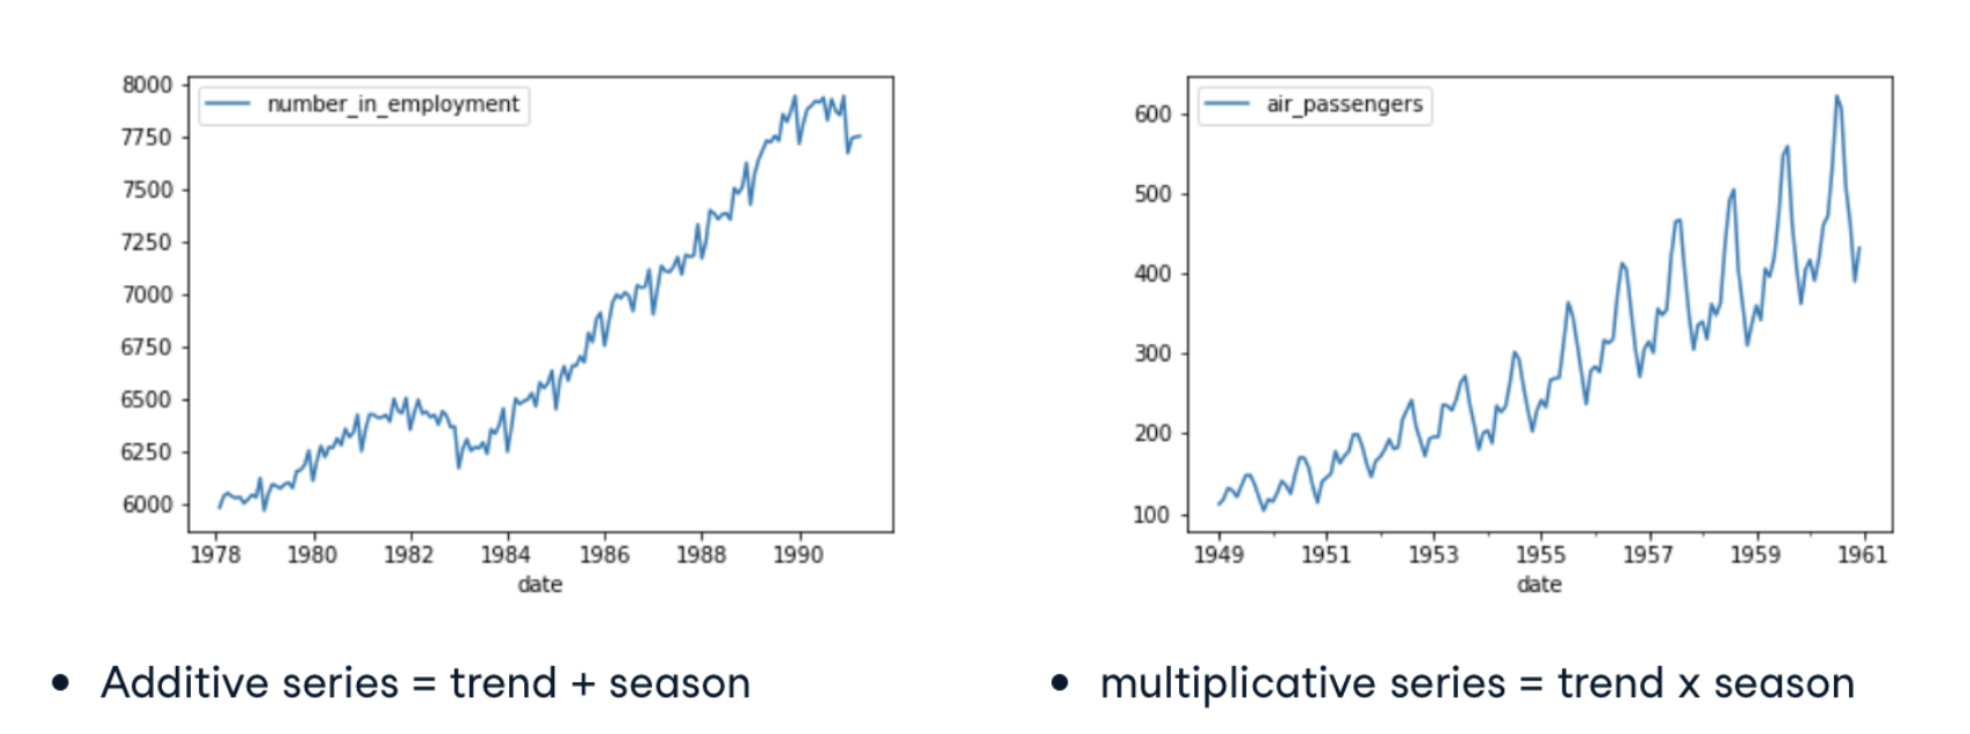

Этот метод не дает информации о типе ошибки, однако в его определении может помочь в определении изображение разложенного временного ряда (посмотрим на него в практической части).

## Модификации модели ETS

Для того, что иметь более подробное представление о том, как различаются модели, можно посмотреть на их уравнения.

Ниже представлены уравнения сначала для моделей с аддитивными ошибками (и всеми комбинациями тренда и сезонности), затем уравнения для моделей с мультипликативными ошибками.




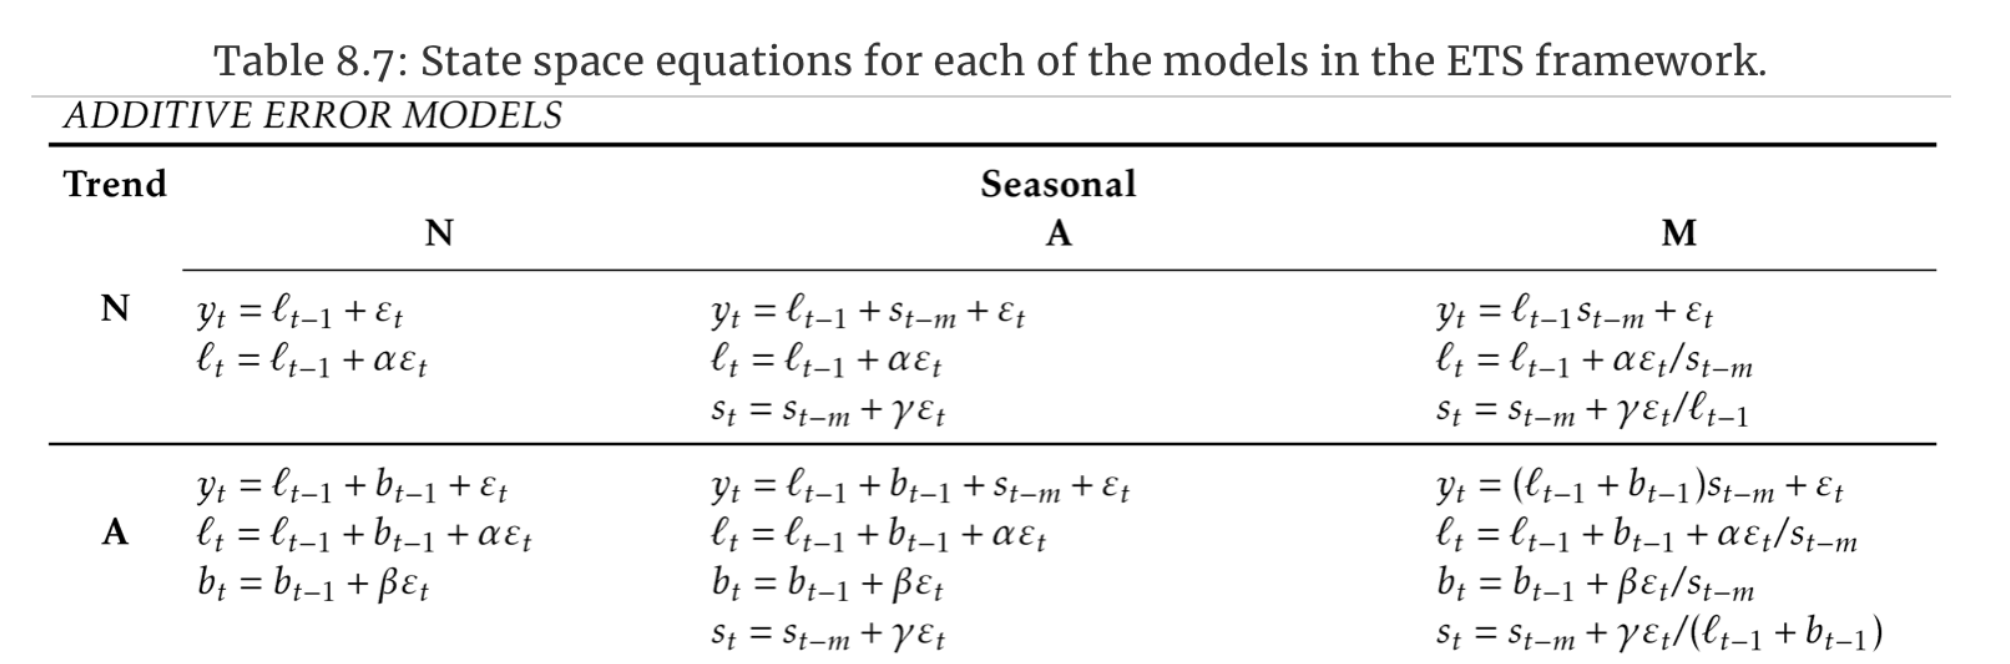

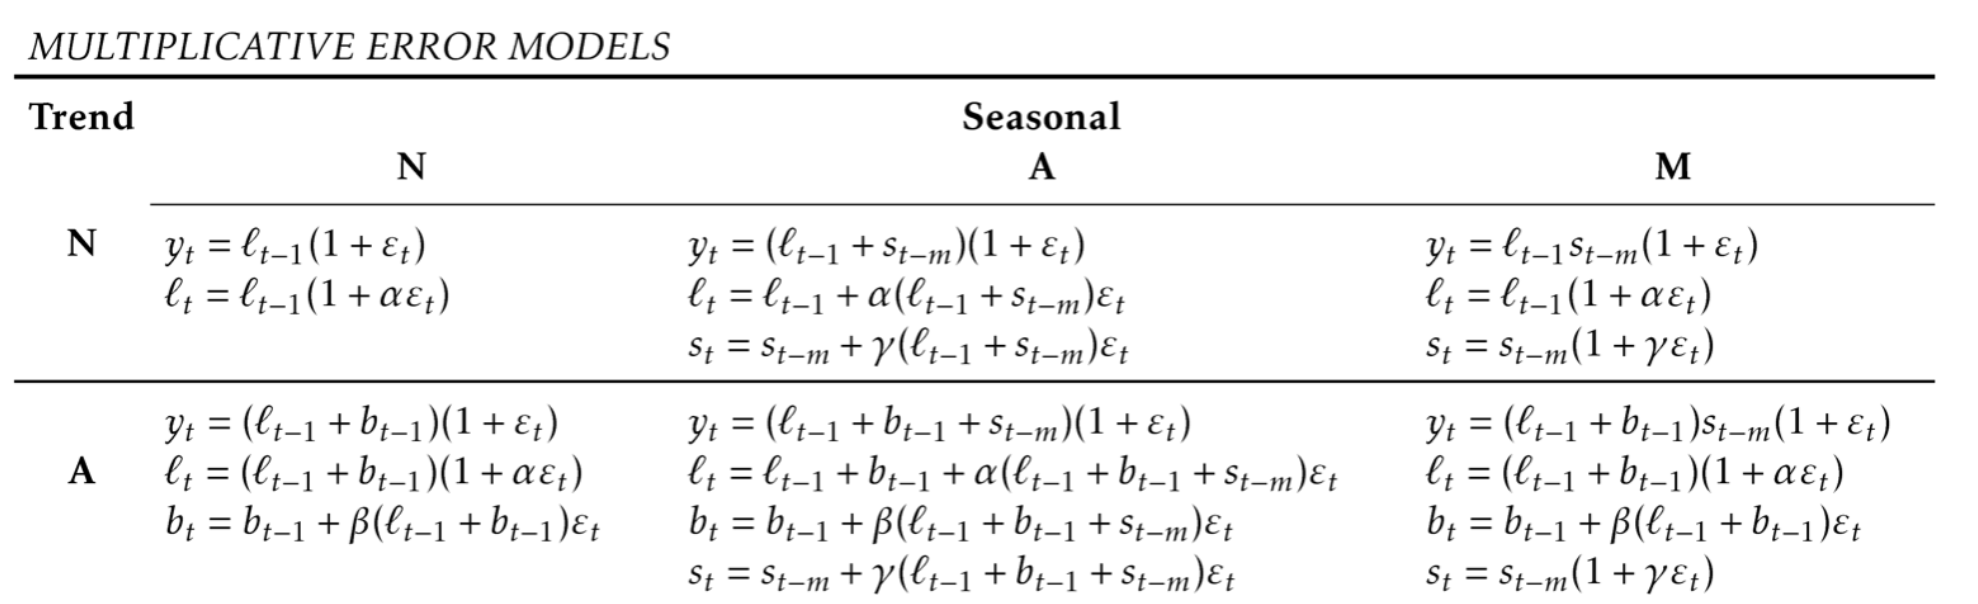

## Полезные ссылки

1.   Подробный [учебник](https://otexts.com/fpp3/ets.html) по временным рядам и моделям (на англ.)




## **Практика**

## Установка библиотеки

Для проведения анализа и прогнозирования будем использовать модуль [sktime](https://www.sktime.org/en/latest/), который предоставляет широкий набор средств и методов для прогнозирования и классификации временных рядов с помощью различных моделей. 

Для Python библиотека ставится с помощью PyPi следующим образом:

In [ ]:
pip install sktime

Кроме того, ее можно установить через conda:

In [ ]:
# conda install -c conda-forge sktime

## Данные



Для анализа и прогнозирования мы будем использовать данные взятые с платформы DataCamp, отражающие ежемесячное производство молока в фунтах. 

(Чаще всего с временными рядами работают в финансовой сфере для предсказания цен активов, однако мы решили посмотреть на эту тему с нежиданной стороны).

Для начала подключим необходимые модули и их атрибуты:

In [169]:
import numpy as np
import pandas as pd

from sktime.utils.plotting import plot_series # позволяет графически представить временной ряд
from sktime.forecasting.model_selection import temporal_train_test_split # разбивает модель на тренировочную и тестовую выборки
from sktime.forecasting.ets import AutoETS # делает автоматический подбор специфицикации модели, т.е. определяет 
from sktime.forecasting.base import ForecastingHorizon 
from statsmodels.tsa.seasonal import seasonal_decompose # раскладывает временной ряд на компоненты
import matplotlib.pyplot as plt # позволяет построить график разложения

Далее загрузим данные и посмотрим на них:

In [ ]:
y = pd.read_csv("https://assets.datacamp.com/production/repositories/4567/datasets/1213fc15035051ef7fe5a0dac44176df7223a93a/milk_production.csv")
y.head()

,date,pounds_per_cow
0,1962-01-01,589.0
1,1962-02-01,561.0
2,1962-03-01,640.0
3,1962-04-01,656.0
4,1962-05-01,727.0


Для того, чтобы работать с данными в sktime, их необходимо привести к определенному формату: index $\rightarrow$ PeriodIndex 

In [ ]:
y['date'] = pd.to_datetime(y['date'])
y = pd.Series(y['pounds_per_cow'].values, index=y['date']) 
y.index = y.index.to_period('M')
y

date
1962-01    589.0
1962-02    561.0
1962-03    640.0
1962-04    656.0
1962-05    727.0
           ...  
1975-08    858.0
1975-09    817.0
1975-10    827.0
1975-11    797.0
1975-12    843.0
Freq: M, Length: 168, dtype: float64

In [ ]:
y.index

PeriodIndex(['1962-01', '1962-02', '1962-03', '1962-04', '1962-05', '1962-06',
             '1962-07', '1962-08', '1962-09', '1962-10',
             ...
             '1975-03', '1975-04', '1975-05', '1975-06', '1975-07', '1975-08',
             '1975-09', '1975-10', '1975-11', '1975-12'],
            dtype='period[M]', name='date', length=168, freq='M')

Более подробно о том, как работать с различными структурами данных в sktime, можно посмотреть [здесь](https://www.sktime.org/en/latest/examples/loading_data.html).

Прежде чем проводить содержательный прогноз временного ряда, необходимо определить, из каких компонент он состоит. Самый простой способ — провести предварительный анализ, взглянув на его графическое изображение.

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4e03e92e10>)

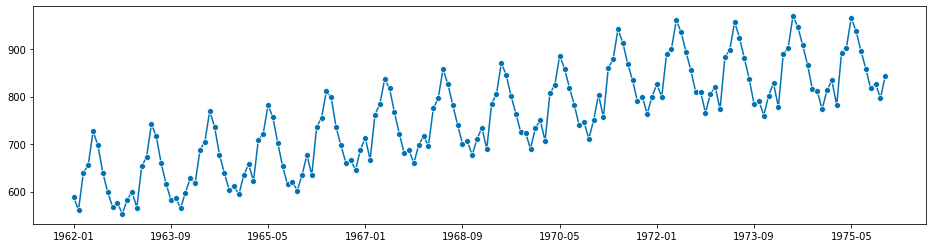

In [ ]:
plot_series(y)

По графику заметно, что в данных присутствует как тренд, так и месячная сезонность, при этом с кажется, что модель скорее аддитивная, так как тренд имеет практически линейный вид, а амплитуда сезонности не меняется со временем. 


Подтвердить эти гипотезы может изображения разложенного временного ряда: 

(К сожалению, в sktime пока не реализована такая функция, поэтому будем использовать библиотеку statsmodels для этих целей).

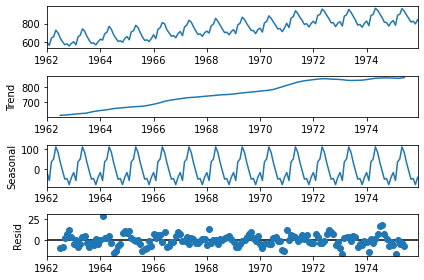

In [182]:
df = pd.read_csv("https://assets.datacamp.com/production/repositories/4567/datasets/1213fc15035051ef7fe5a0dac44176df7223a93a/milk_production.csv")
# для statsmodels формат данных нужен другой, поэтому загрузим и преобразуем наши данные еще раз

df['date'] = pd.to_datetime(df['date'])
df = pd.Series(df['pounds_per_cow'].values , index=df['date']).fillna(0) 
df = df.asfreq('MS')

decompose = seasonal_decompose(df)

decompose.plot()
plt.show()

Графики тренда и сезонного фактора доказывают нашу гипотезу. Так же можно заметить, что разброс ошибок в целом не меняется со временем.

Исходя из полученной информации можно предположить, что наиболее подходящая модель для данного временного ряда - это ETS(A, A, A), которая формульно записывается как: 

$$y_t = l_{t-1} + b_{t-1} + s_{t-m} + \epsilon_t$$
$$l_t = l_{t-1} + b_{t-1} + \alpha\epsilon_t$$
$$b_t = b_{t-1} + \beta\epsilon_t$$
$$s_t = s_{t-m} + \gamma\epsilon_t$$

## Обучение модели

Для начала разобьем наш ряд на обучающую и тестовую выборки:

In [ ]:
y_train, y_test = temporal_train_test_split(y)

Функция temporal_train_test_split (без указания дополнительных параметров) делит выборку в соотношении 80% - обучающая, 20% - тестовая).

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4e03e5d400>)

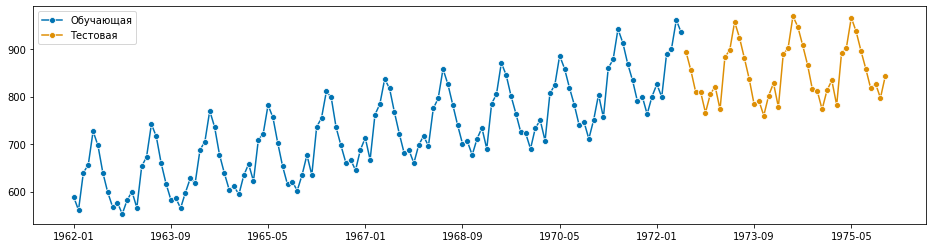

In [ ]:
plot_series(y_train, y_test, labels=['Обучающая', 'Тестовая'])

Однако мы видим четкий развыв между обучающими и тестовыми даными, где маленький кусочек данных не попадает ни в одну выбоку. Чтобы избежать последствий из-за потери этих данных, изменим соотношение, указав размер тестовой выборки взяв последние 3 года. 

(Так как каждая точка временного ряда представляет собой месяц, нужно указывать месяц * количество лет, т.е. 12 * 3 = 36).

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4e03d9b0f0>)

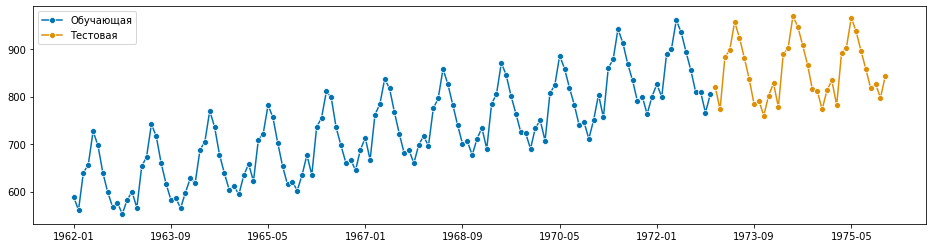

In [ ]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_series(y_train, y_test, labels=['Обучающая', 'Тестовая'])

Ранее мы уже предположили вид модели, а именно ETS(A, A, A). Настало время ее обучить.

In [ ]:
ets_aaa = AutoETS(error='add', trend='add', seasonal='add', sp=12).fit(y_train)
ets_aaa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:                       ETS(AAA)   Log Likelihood                -439.018
Date:                Wed, 03 Feb 2021   AIC                            914.036
Time:                        14:36:21   BIC                            965.926
Sample:                    01-31-1962   HQIC                           935.122
                         - 12-31-1972   Scale                           45.327
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6830      0.077      8.925      0.000       0.533       0.833
smoothing_trend       6.83e-05        nan        nan        nan         nan         nan
smoothing_seasonal    3.17e-05        nan        nan        nan         nan         nan
initial_level         588.1179        nan        nan        nan         nan         nan
initial_trend           1.8476      0.406      4.550      0.000       1.052       2.643
initial_seasonal.0    -25.7706        nan        nan        nan         nan         nan
initial_seasonal.1    -61.1977        nan        nan        nan         nan         nan
initial_seasonal.2    -31.1680        nan        nan        nan         nan         nan
initial_seasonal.3    -34.6887        nan        nan        nan         nan         nan
initial_seasonal.4      5.8872        nan        nan        nan         nan         nan
initial_seasonal.5     48.1928        nan        nan        nan         nan         nan
initial_seasonal.6    100.0376        nan        nan        nan         nan         nan
initial_seasonal.7    128.1576        nan        nan        nan         nan         nan
initial_seasonal.8     67.3701        nan        nan        nan         nan         nan
initial_seasonal.9     51.6747        nan        nan        nan         nan         nan
initial_seasonal.10   -36.2960        nan        nan        nan         nan         nan
initial_seasonal.11          0        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       18.73   Jarque-Bera (JB):                25.05
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.63
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Напомним, что в общем виде модель имеет вид:

$$y_t = l_{t-1} + b_{t-1} + s_{t-m} + \epsilon_t$$
$$l_t = l_{t-1} + b_{t-1} + \alpha\epsilon_t$$
$$b_t = b_{t-1} + \beta\epsilon_t$$
$$s_t = s_{t-m} + \gamma\epsilon_t$$



Для создания прогноза нам необходимо было оценить сглаживающие параметры модели: $\alpha, \beta, \gamma$, а также начальные состояния: $l_0, b_0, s_{-0}, \dots, s_{-m+1}.$ В нашем случае, сезонность месячная (m=12), поэтому оцениваются значения $s_{-0}, \dots, s_{-11}$.

Так, подставляя полученные на обучающей выборке коэффициенты, мы имеем:

$$y_t = l_{t-1} + b_{t-1} + s_{t-m} + \epsilon_t$$
$$l_t = l_{t-1} + b_{t-1} + 0.683\epsilon_t$$
$$b_t = b_{t-1} + 0.0000683\epsilon_t$$
$$s_t = s_{t-m} + 0.0000317\epsilon_t,$$

где $l_0 = 588.1179, b_0 = 1.8476, s_{-0} = -25.77, s_{-1} = -61.19, \dots , s_{-11} = 0.$

## Прогнозирование

Построим прогноз на тестовой выборке, используя полученную модель. В sktime для этого необходимо вначале задать горизонт прогнозирования, используя абсолютные временные точки, которые мы хотим предсказать (например, с помощью класса ForecastingHorizon).

In [ ]:
horizon = ForecastingHorizon(y_test.index, is_relative=False)
horizon

ForecastingHorizon(['1973-01', '1973-02', '1973-03', '1973-04', '1973-05', '1973-06',
             '1973-07', '1973-08', '1973-09', '1973-10', '1973-11', '1973-12',
             '1974-01', '1974-02', '1974-03', '1974-04', '1974-05', '1974-06',
             '1974-07', '1974-08', '1974-09', '1974-10', '1974-11', '1974-12',
             '1975-01', '1975-02', '1975-03', '1975-04', '1975-05', '1975-06',
             '1975-07', '1975-08', '1975-09', '1975-10', '1975-11', '1975-12'],
            dtype='period[M]', name='date', freq='M', is_relative=False)

In [ ]:
y_pred_aaa = ets_aaa.predict(horizon)
y_pred_aaa.head()

date
1973-01    833.860244
1973-02    799.411824
1973-03    889.230178
1973-04    906.773208
1973-05    969.408265
Freq: M, dtype: float64

Посмотрим на график, чтобы определить качество прогноза:

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4e046966a0>)

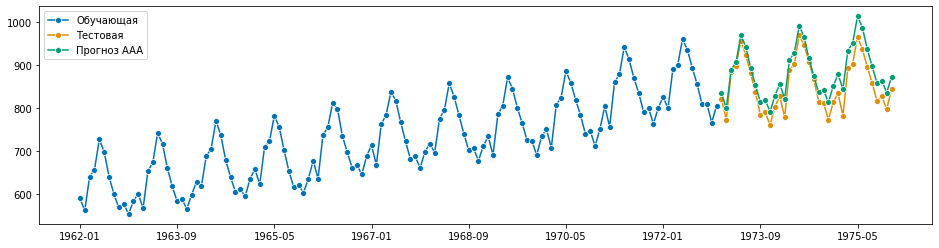

In [ ]:
plot_series(y_train, y_test, y_pred_aaa, labels=['Обучающая', 'Тестовая', 'Прогноз AAA'])

Видно, что прогноз очень близок к настоящим значения, а значит выбранная нами модель хорошо описывает временной ряд.


## Автоматический подбор модели

Помимо других удобных методов, в sktime есть возможность автоматического подбора модели ETS. Давайте воспользуемся им и сравним результаты.

In [ ]:
ets_auto = AutoETS(auto=True, sp=12).fit(y_train)
ets_auto.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/exponential_smoothing/ets.py:1135: RuntimeWarning: invalid value encountered in log
  logL -= np.sum(np.log(yhat))


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:                       ETS(AAA)   Log Likelihood                -439.018
Date:                Wed, 03 Feb 2021   AIC                            914.036
Time:                        13:42:01   BIC                            965.926
Sample:                    01-31-1962   HQIC                           935.122
                         - 12-31-1972   Scale                           45.327
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6830      0.077      8.925      0.000       0.533       0.833
smoothing_trend       6.83e-05        nan        nan        nan         nan         nan
smoothing_seasonal    3.17e-05        nan        nan        nan         nan         nan
initial_level         588.1179        nan        nan        nan         nan         nan
initial_trend           1.8476      0.406      4.550      0.000       1.052       2.643
initial_seasonal.0    -25.7706        nan        nan        nan         nan         nan
initial_seasonal.1    -61.1977        nan        nan        nan         nan         nan
initial_seasonal.2    -31.1680        nan        nan        nan         nan         nan
initial_seasonal.3    -34.6887        nan        nan        nan         nan         nan
initial_seasonal.4      5.8872        nan        nan        nan         nan         nan
initial_seasonal.5     48.1928        nan        nan        nan         nan         nan
initial_seasonal.6    100.0376        nan        nan        nan         nan         nan
initial_seasonal.7    128.1576        nan        nan        nan         nan         nan
initial_seasonal.8     67.3701        nan        nan        nan         nan         nan
initial_seasonal.9     51.6747        nan        nan        nan         nan         nan
initial_seasonal.10   -36.2960        nan        nan        nan         nan         nan
initial_seasonal.11          0        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       18.73   Jarque-Bera (JB):                25.05
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.63
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Автоподбор также указал на модель ETS(A, A, A), то есть наше предположение об аддитивности всех компонентов модели оказалось верным! Это еще раз подчеркивает важность проведения анализа самого ряда перед построением моделей.

## Сравнение моделей с помощью скользящего окна

Доделать!

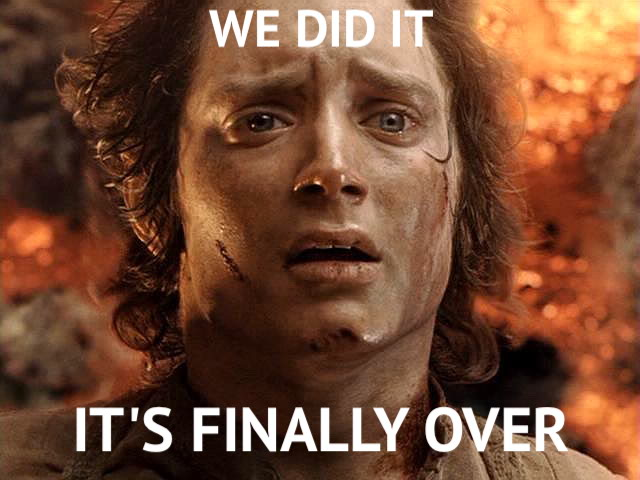